# Importing frameworks

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense, Activation, Dropout
import keras
from sklearn import metrics
import itertools
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import cross_validate
import json
import joblib
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

# Функции

In [37]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [38]:
def get_result(y_true, y_pred, get_scores=True, get_plot=True, get_percents=True):
    result_scores = [round(metrics.accuracy_score(y_true, y_pred),2), round(metrics.f1_score(y_true, y_pred),2), round(metrics.precision_score(y_true, y_pred),2), round(metrics.recall_score(y_true, y_pred),2)]
    if get_scores:
        print(f'\nMetrics in test:\nAccuracy {result_scores[0]}\nF1 score {result_scores[1]}\nPrecision {result_scores[2]}\nRecall {result_scores[3]}', end='\n\n')
    cnf_matrix = metrics.confusion_matrix(y_true, y_pred)
    if get_plot:
        plot_confusion_matrix(cnf_matrix, ['GOOD', 'BAD'], title='Confusion matrix - LinearRegression', cmap=plt.cm.Blues)
    if get_percents:
        print(f'{round((cnf_matrix[1][0]) / (cnf_matrix[1][0]+cnf_matrix[1][1]) * 100, 2)}% среди плохих заемщиков был одобрен кредит')
        print(f'{round((cnf_matrix[1][1]) / (cnf_matrix[1][0]+cnf_matrix[1][1]) * 100, 2)}% среди плохих заемщиков были определены как плохие', end='\n\n')
        print(f'{round((cnf_matrix[0][1]) / (cnf_matrix[0][0]+cnf_matrix[0][1]) * 100, 2)}% среди хороших заемщиков было отказано в кредите')
        print(f'{round((cnf_matrix[0][0]) / (cnf_matrix[0][0]+cnf_matrix[0][1]) * 100, 2)}% среди хороших заемщиков были определены как хорошие')
    return result_scores

In [39]:
def get_bin_pred(arr, threshold):
  return np.array([x >= threshold for x in arr])

In [40]:
from DataPreprocessing import DataPreprocessing

In [41]:
def LearningPlots(x_range, train_metrics, test_metrics):
  
  plt.figure(figsize=(20,5))

  plt.subplot(*[1, 4, 1], title='F1-score')
  plt.plot(x_range, train_metrics['f1'], label='Train')
  plt.plot(x_range, test_metrics['f1'], label='Validation')
  plt.legend()

  plt.subplot(*[1, 4, 2], title='Precision')
  plt.plot(x_range, train_metrics['precision'], label='Train')
  plt.plot(x_range, test_metrics['precision'], label='Validation')
  plt.legend()

  plt.subplot(*[1, 4, 3], title='Accuracy')
  plt.plot(x_range, train_metrics['accuracy'], label='Train')
  plt.plot(x_range, test_metrics['accuracy'], label='Validation')
  plt.legend()

  plt.subplot(*[1, 4, 4], title='Recall')
  plt.plot(x_range, train_metrics['recall'], label='Train')
  plt.plot(x_range, test_metrics['recall'], label='Validation')
  plt.legend()

  plt.show()

class ModelMetrics():
  def __init__(self):
    self.accuracy = []
    self.f1 = []
    self.precision = []
    self.recall = []

    self.accuracy_val = []
    self.f1_val = []
    self.precision_val = []
    self.recall_val = []

  def AddMetrics(self, y_true, y_pred, type):
    if type == 'validation':
      self.accuracy_val += [metrics.accuracy_score(y_true, y_pred)]
      self.f1_val += [metrics.f1_score(y_true, y_pred)]
      self.precision_val += [metrics.precision_score(y_true, y_pred)]
      self.recall_val += [metrics.recall_score(y_true, y_pred)]
      return
    if type == 'train':
      self.accuracy += [metrics.accuracy_score(y_true, y_pred)]
      self.f1 += [metrics.f1_score(y_true, y_pred)]
      self.precision += [metrics.precision_score(y_true, y_pred)]
      self.recall += [metrics.recall_score(y_true, y_pred)]
      return
  
  def SetMetrics(self, metrics_dict, type):
    if type == 'validation':
      self.accuracy_val = metrics_dict['accuracy']
      self.f1_val = metrics_dict['f1']
      self.precision_val = metrics_dict['precision']
      self.recall_val = metrics_dict['recall']
      return
    if type == 'train':
      self.accuracy = metrics_dict['accuracy']
      self.f1 = metrics_dict['f1']
      self.precision = metrics_dict['precision']
      self.recall = metrics_dict['recall']
      return

  def GetTrainMetrics(self):
    return {'accuracy':self.accuracy, 'f1':self.f1, 'precision':self.precision, 'recall':self.recall}
  
  def GetValidationMetrics(self):
    return {'accuracy':self.accuracy_val, 'f1':self.f1_val, 'precision':self.precision_val, 'recall':self.recall_val}


In [42]:
def PlotFeatureImportances(col_names, importances, name=""):
    
    indices = np.argsort(importances)

    plt.figure(figsize=(10,10))
    plt.title(f'Feature Importances - {name}')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [col_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()  

# Loading and preprocessing dataset

In [43]:
d = pd.read_csv(r"C:\Users\71380279\Desktop\DataPreprocessing\hmeq.csv", encoding='utf-8', sep=',')

In [44]:
#ValsToReplaceNan = dict()
#ValsToReplaceNan['MORTDUE'] = temp['MORTDUE']['mean']
#ValsToReplaceNan['VALUE'] = temp['VALUE']['mean']
#ValsToReplaceNan['DEROG'] = 0
#ValsToReplaceNan['DELINQ'] = 0
#ValsToReplaceNan['CLAGE'] = 0
#ValsToReplaceNan['NINQ'] = temp['NINQ']['mean']
#ValsToReplaceNan['DEBTINC'] = temp['DEBTINC']['max']

In [45]:
#with open('ValsToRepaceNan.json', 'w') as write_file:
#    json.dump(ValsToReplaceNan, write_file)

In [46]:
df = DataPreprocessing(d)

In [47]:
df.ReplaceNanValues("AddNewFeatures")

In [48]:
df.CategoricalRecoding("OneHotEncoder")

In [49]:
df.TrainTestValSplit(test_size=500, validation_size=500)

In [50]:
df.Balancing("SMOTE")

In [51]:
df.FeatureSelection(k=9, after_split=True)

,LOAN,MORTDUE,VALUE,DEROG,DELINQ,CLAGE,NINQ,DEBTINC,INCOME,BAD
0,1100.0,25860.0000,39025.000000,0.0,0.0,94.366667,1.000000,203.312149,0.0,1
1,1300.0,70053.0000,68400.000000,0.0,2.0,121.833333,0.000000,203.312149,0.0,1
2,1500.0,13500.0000,16700.000000,0.0,0.0,149.466667,1.000000,203.312149,0.0,1
3,1500.0,73760.8172,101776.048741,0.0,0.0,0.000000,1.186055,203.312149,0.0,1
4,1700.0,97800.0000,112000.000000,0.0,0.0,93.333333,0.000000,203.312149,0.0,0
...,...,...,...,...,...,...,...,...,...,...
5955,88900.0,57264.0000,90185.000000,0.0,0.0,221.808718,0.000000,36.112347,1.0,0
5956,89000.0,54576.0000,92937.000000,0.0,0.0,208.692070,0.000000,35.859971,1.0,0
5957,89200.0,54045.0000,92924.000000,0.0,0.0,212.279697,0.000000,35.556590,1.0,0
5958,89800.0,50370.0000,91861.000000,0.0,0.0,213.892709,0.000000,34.340882,1.0,0


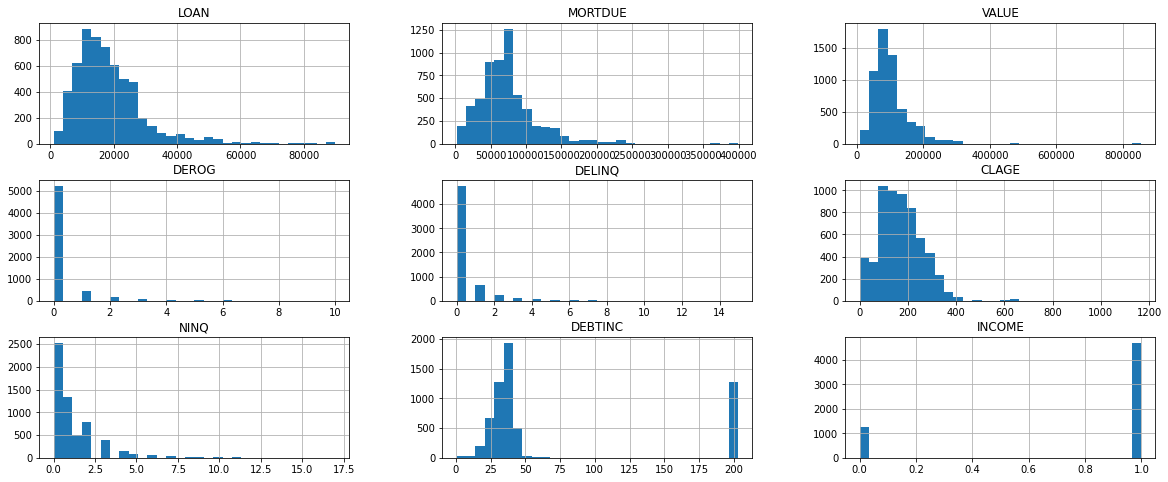

In [52]:
df.PlotFeatureDist()

In [53]:
min_b, max_b = df.Normalization('Normalization', [1,1,1,0,0,1,0,1,2])

In [54]:
with open("min_borders.json", "w") as write_file:
    json.dump(min_b, write_file)

with open("max_borders.json", "w") as write_file:
    json.dump(max_b, write_file)

In [55]:
X_train, y_train = df.GetTrain()
X_test, y_test = df.GetTest()
X_validation, y_validation = df.GetValidation()

In [56]:
pd.concat([X_train, y_train], axis=1).to_csv('Data_trian.csv', index=False)
pd.concat([X_test, y_test], axis=1).to_csv('Data_test.csv', index=False)
pd.concat([X_validation, y_validation], axis=1).to_csv('Data_validation.csv', index=False)

# SVC


Metrics in test:
Accuracy 0.88
F1 score 0.88
Precision 0.89
Recall 0.88



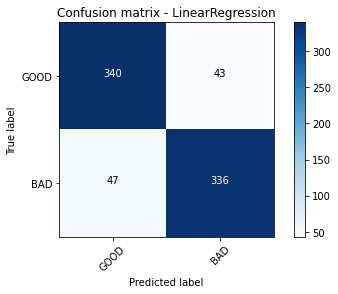

12.27% среди плохих заемщиков был одобрен кредит
87.73% среди плохих заемщиков были определены как плохие

11.23% среди хороших заемщиков было отказано в кредите
88.77% среди хороших заемщиков были определены как хорошие


In [57]:
svc = svm.SVC(C=50)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

a2, f2, p2, r2 = get_result(y_test, y_pred)

# Random Forest Regression

In [ ]:

model_metrics = ModelMetrics()

max_depth_values = range(1,30)
for max_depth in max_depth_values:
    forest = RandomForestRegressor(max_depth=max_depth)
    forest.fit(X_train, y_train)

    y_pred = forest.predict(X_train)
    threshold = np.quantile(y_pred, 0.5)
    y_pred = get_bin_pred(y_pred, threshold)

    model_metrics.AddMetrics(y_train, y_pred, 'train')

    y_pred = get_bin_pred(forest.predict(X_validation), threshold)
    model_metrics.AddMetrics(y_validation, y_pred, 'validation')

    print(f'\rmax_depth = {max_depth}/{max_depth_values[-1]}', end='')

LearningPlots(max_depth_values, model_metrics.GetTrainMetrics(), model_metrics.GetValidationMetrics())

In [59]:
forest_regressor = RandomForestRegressor(max_depth=15)
forest_regressor.fit(X_train, y_train)

y_pred = forest_regressor.predict(X_train)
threshold = np.quantile(y_pred, 0.5)

In [60]:
threshold

0.3497849503997372

In [44]:
with open("threshold.json", "w") as write_file:
    json.dump(threshold, write_file)

In [ ]:
y_pred = forest_regressor.predict(X_test)
y_pred = get_bin_pred(y_pred, threshold)
a0, f0, p0, r0 = get_result(y_test, y_pred)

In [45]:
y_pred = forest_regressor.predict(X_train)

In [46]:
joblib.dump(forest_regressor, "RFR_model.joblib")

['RFR.joblib']

# Linear Regression


Metrics in test:
Accuracy 0.86
F1 score 0.87
Precision 0.83
Recall 0.91



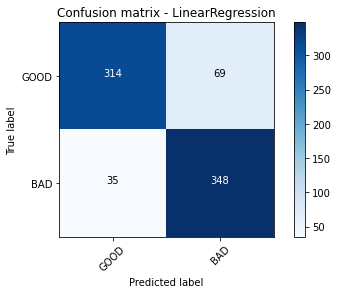

9.14% среди плохих заемщиков был одобрен кредит
90.86% среди плохих заемщиков были определены как плохие

18.02% среди хороших заемщиков было отказано в кредите
81.98% среди хороших заемщиков были определены как хорошие


In [39]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_train)

threshold = np.quantile(y_pred, 0.5)

y_pred = get_bin_pred(regressor.predict(X_test), threshold)
a1, f1, p1, r1 = get_result(y_test, y_pred)

# Random Forest Classifier

max_depth = 29/29

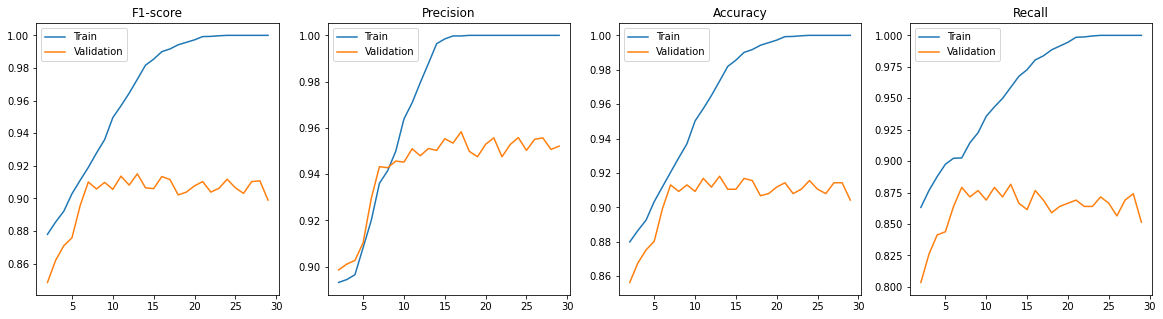

In [94]:
model_metrics = ModelMetrics()

max_depth_values = range(2,30)
for max_depth in max_depth_values:
    forest = RandomForestClassifier(max_depth=max_depth)
    forest.fit(X_train, y_train)

    y_pred = forest.predict(X_train)
    model_metrics.AddMetrics(y_train, y_pred, 'train')

    y_pred = forest.predict(X_validation)
    model_metrics.AddMetrics(y_validation, y_pred, 'validation')

    print(f'\rmax_depth = {max_depth}/{max_depth_values[-1]}', end='')

LearningPlots(max_depth_values, model_metrics.GetTrainMetrics(), model_metrics.GetValidationMetrics())


Metrics in test:
Accuracy 0.92
F1 score 0.92
Precision 0.94
Recall 0.91



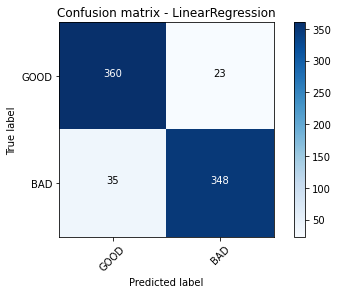

9.14% среди плохих заемщиков был одобрен кредит
90.86% среди плохих заемщиков были определены как плохие

6.01% среди хороших заемщиков было отказано в кредите
93.99% среди хороших заемщиков были определены как хорошие


In [54]:
forest = RandomForestClassifier(max_depth=14)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)
a3, f3, p3, r3 = get_result(y_test, y_pred)

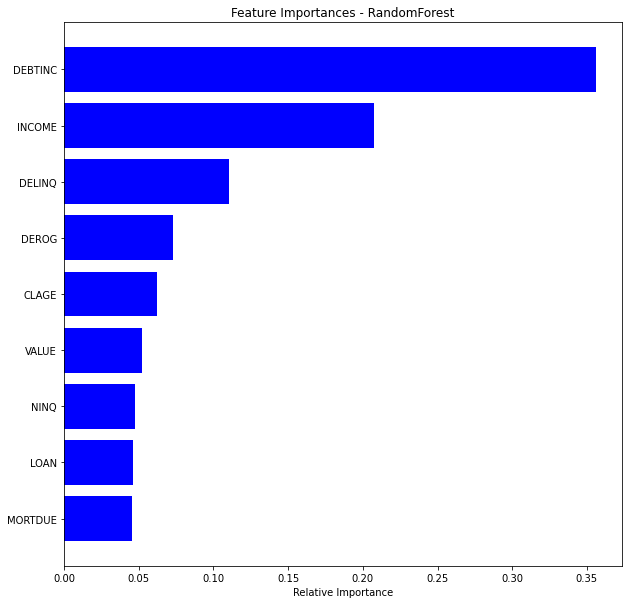

In [96]:
PlotFeatureImportances(X_train.columns, forest.feature_importances_, name="RandomForest")

# Decision Tree Classifier

max_depth = 14/14

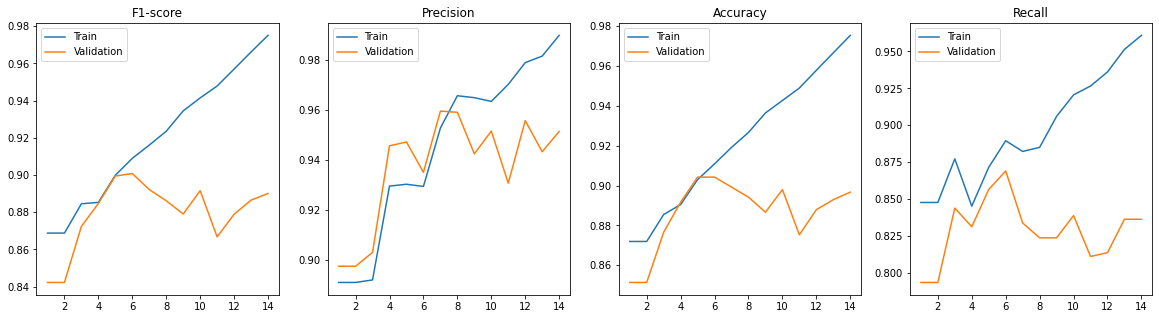

In [41]:
model_metrics = ModelMetrics()

max_depth_values = range(1,15)
for max_depth in max_depth_values:
  tree = DecisionTreeClassifier(max_depth=max_depth)
  tree.fit(X_train, y_train)

  y_pred = tree.predict(X_train)
  model_metrics.AddMetrics(y_train, y_pred, 'train')

  y_pred = tree.predict(X_validation)
  model_metrics.AddMetrics(y_validation, y_pred, 'validation')

  print(f'\rmax_depth = {max_depth}/{max_depth_values[-1]}', end='')

LearningPlots(max_depth_values, model_metrics.GetTrainMetrics(), model_metrics.GetValidationMetrics())


Metrics in test:
Accuracy 0.9
F1 score 0.9
Precision 0.93
Recall 0.87



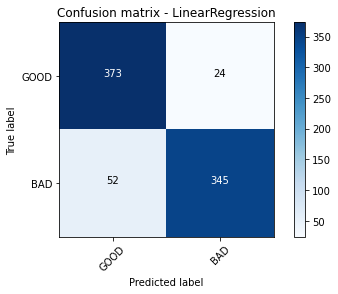

13.1% среди плохих заемщиков был одобрен кредит
86.9% среди плохих заемщиков были определены как плохие

6.05% среди хороших заемщиков было отказано в кредите
93.95% среди хороших заемщиков были определены как хорошие


In [42]:
tree_model = DecisionTreeClassifier(max_depth=6)
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_validation)

a4, f4, p4, r4 = get_result(y_validation, y_pred)

In [99]:
#plt.figure(figsize=(50,30))
#tree.plot_tree(tree_model, feature_names=X_train.columns);

# Neiral Network

In [43]:
nn_model = Sequential([
            Dense(20, activation='relu'),
            Dropout(0.5),
            Dense(14, activation='relu'),
            Dropout(0.5),
            Dense(7, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')])

EPOCHS = 70

nn_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Recall(), keras.metrics.Precision()])

history = nn_model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_validation, y_validation), shuffle=True, verbose=0)

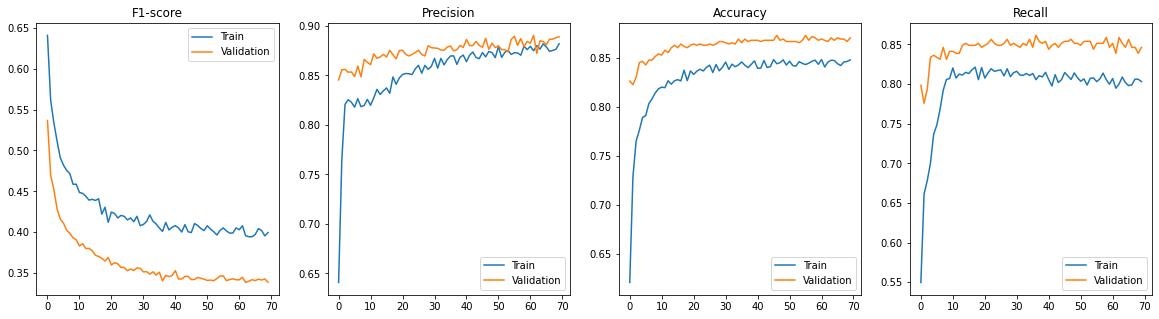

In [44]:
key_names = list(history.history.keys())

train_loss = history.history[key_names[0]]
val_loss = history.history[key_names[4]]

train_accuracy = history.history[key_names[1]]
val_accuracy = history.history[key_names[5]]

train_recall = history.history[key_names[2]]
val_recall = history.history[key_names[6]]

train_precision = history.history[key_names[3]]
val_precision = history.history[key_names[7]]

model_metrics = ModelMetrics()
model_metrics.SetMetrics({'accuracy': train_accuracy, 'f1':train_loss, 'precision': train_precision, 'recall':train_recall}, 'train')
model_metrics.SetMetrics({'accuracy': val_accuracy, 'f1':val_loss, 'precision': val_precision, 'recall':val_recall}, 'validation')

LearningPlots(range(EPOCHS), model_metrics.GetTrainMetrics(), model_metrics.GetValidationMetrics())

24/24 [==============================] - 0s 1000us/step

Metrics in test:
Accuracy 0.87
F1 score 0.88
Precision 0.85
Recall 0.91



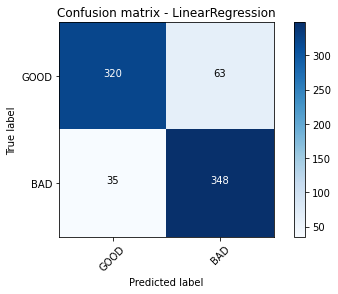

9.14% среди плохих заемщиков был одобрен кредит
90.86% среди плохих заемщиков были определены как плохие

16.45% среди хороших заемщиков было отказано в кредите
83.55% среди хороших заемщиков были определены как хорошие


In [45]:
y_pred = nn_model.predict(X_train)

threshold = np.quantile(y_pred, 0.5)

y_pred = get_bin_pred(nn_model.predict(X_test), threshold)

a5, f5, p5, r5 = get_result(y_test, y_pred)

# CatBoost

In [50]:
#pip install catboost
from catboost import CatBoostClassifier
cat = CatBoostClassifier(1500, max_depth=3, learning_rate=0.1, custom_loss=['AUC', 'Accuracy', 'Recall', 'Precision', 'F1'], random_seed=62, verbose=0)
cat.fit(X_train, y_train, metric_period=1, plot=True, eval_set=(X_validation, y_validation))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Metrics in test:
Accuracy 0.94
F1 score 0.94
Precision 0.96
Recall 0.92



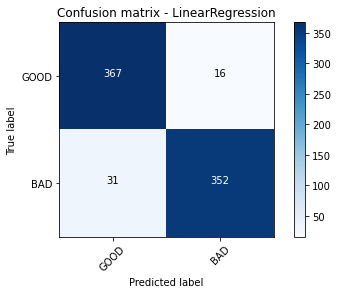

8.09% среди плохих заемщиков был одобрен кредит
91.91% среди плохих заемщиков были определены как плохие

4.18% среди хороших заемщиков было отказано в кредите
95.82% среди хороших заемщиков были определены как хорошие


In [51]:
y_pred = cat.predict(X_test)

a6, f6, p6, r6 = get_result(y_test, y_pred)

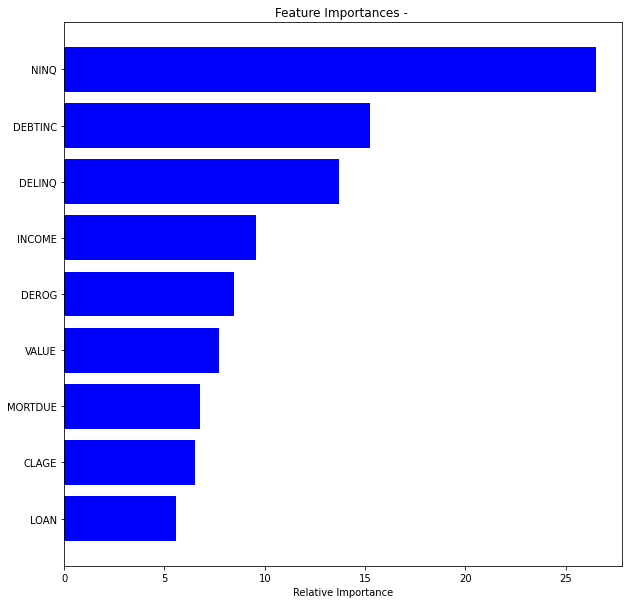

In [52]:
PlotFeatureImportances(X_train.columns, cat.feature_importances_)

In [58]:
with_SMOTE = pd.DataFrame({'Model':['Random Forest Regression','Linear Regression', 'SVC', 'Random Forest Classifier', 'Decision Tree', 'Neiral Network', 'CatBoost'],
              'Accuracy':[a0,a1,a2,a3,a4,a5,a6],
              'Presicion':[p0,p1,p2,p3,p4,p5,p6],
              'Recall':[r0,r1,r2,r3,r4,r5,r6],
              'F1':[f0,f1,f2,f3,f4,f5,f6],
              'Oversampling method':['SMOTE','SMOTE','SMOTE','SMOTE','SMOTE','SMOTE','SMOTE']}).set_index('Model')

In [59]:
with_SMOTE

,Accuracy,Presicion,Recall,F1,Oversampling method
Model,,,,,
Random Forest Regression,0.93,0.91,0.95,0.93,SMOTE
Linear Regression,0.86,0.83,0.91,0.87,SMOTE
SVC,0.88,0.89,0.88,0.88,SMOTE
Random Forest Classifier,0.92,0.94,0.91,0.92,SMOTE
Decision Tree,0.90,0.93,0.87,0.90,SMOTE
Neiral Network,0.87,0.85,0.91,0.88,SMOTE
CatBoost,0.94,0.96,0.92,0.94,SMOTE


<AxesSubplot:>

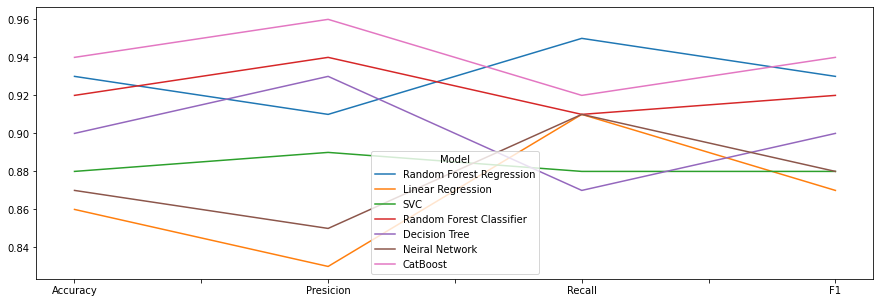

In [60]:
with_SMOTE.drop(['Oversampling method'],axis=1).T.plot(figsize=(15,5))

Сохраним модель CatBoost

In [61]:
cat.save_model(fname='cat_model.cbm',format='cbm')